In [1]:
import numpy as np
from frameDeflection import calculate_frame_deflection as cfd
from frameDeflection import equivalent_nodal_loads as enl
import matplotlib.pyplot as plt

In [2]:
# Structure constants
E = 200e9  # Young's modulus
R = 0.03 # Radius 
I = np.pi * R**4 / 4  # Moment of inertia for a circular cross-section
AREA = np.pi * R**2  # Cross-sectional area
NNEL = 2  # Number of nodes per element
NDOF = 3  # Degrees of freedom per node

# Especific problem constants
L = 6
H1 = 5
H2 = 3
A = 1
B = 1
Q1 = -10e3
Q2 = -10e3
F = 0

In [3]:
def solvePN(ppe = 1):
    """
    Solve the frame deflection problem with a given number of partitions per element.

        Parameters:
            ppe : int
                Number of partitions per element
        Returns:
            cfd_results : dict
                Results from the frame deflection calculation
    """


    nel = 5 * ppe  # number of elements
    nodes = []

    # First primary element (vertical from 0 to H1)
    for i in range(0, ppe + 1):
        nodes.append((0.0, i*H1/ppe))
    
    # Second primary element (horizontal from 0 to A)
    for i in range(1, ppe + 1):
        nodes.append((i*A/ppe, H1))
    # Third primary element (horizontal from A to L)
    for i in range(1, ppe + 1):
        nodes.append((A + i*(L-A)/ppe, H1))

    # Fourth primary element (vertical from H1 down by B)
    for i in range(1, ppe + 1):
        nodes.append((L, H1 - i*B/ppe))
    
    # Fifth primary element (vertical from H1-B down to H1-H2)
    for i in range(1, ppe + 1):
        nodes.append((L, H1 - B - i*(H2 - B)/ppe))

    x = np.array([i for [i, _] in nodes])
    y = np.array([j for [_, j] in nodes])

    nnode = (NNEL - 1) * nel + 1  # total number of nodes in system
    sdof = nnode * NDOF           # total system dofs

    bcdof = np.array([0, 1, 2, sdof-3, sdof-2, sdof-1])  # Fixed DOFs at node 0 and 5
    bcval = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # Corresponding boundary values

    fdof2 = (NNEL - 1) * ppe * NDOF  # first dof of primary element 2
    fdof4 = (NNEL - 1) * 3 * ppe * NDOF  # first dof of primary element 4

    applied_forces = {}

    for i in range(ppe):
        f1 = enl(Q1, A / ppe)
        f2 = enl(Q2, B / ppe, True)
        for j in range(6):  # 6 componentes do vetor de forças
            dof2 = fdof2 + i * NDOF * (NNEL - 1) + j
            applied_forces[dof2] = f1[j]
            dof4 = fdof4 + i * NDOF * (NNEL - 1) + j
            applied_forces[dof4] = f2[j]

    cfd_results = cfd(nel, NNEL, NDOF, x, y, E, AREA, I, bcdof, bcval, applied_forces)

    return cfd_results, x, y


In [4]:
def plot_deformed_frame(cfd_results, x, y, scale=100):
    """
    Plot the deformed configuration of the frame based on the deflection results.
    
    Parameters:
        cfd_results : dict
            Dictionary containing displacements for each degree of freedom
        scale : float
            Scale factor to amplify the deformations for visualization
    """
    # Extract original node positions
    x_original = x.copy()
    y_original = y.copy()
    
    # Calculate deformed positions
    x_deformed = x_original.copy()
    y_deformed = y_original.copy()
    
    for i in range(len(x_original)):
        dof_x = i * NDOF      # DOF for x displacement
        dof_y = i * NDOF + 1  # DOF for y displacement
        
        if dof_x in cfd_results:
            x_deformed[i] += scale * cfd_results[dof_x]
        if dof_y in cfd_results:
            y_deformed[i] += scale * cfd_results[dof_y]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot original configuration
    plt.plot(x_original, y_original, 'b-o', linewidth=2, markersize=8, label='Original')
    
    # Plot deformed configuration
    plt.plot(x_deformed, y_deformed, 'r--s', linewidth=2, markersize=6, label=f'Deformed (scale={scale})')
    
    # Add labels and formatting
    plt.xlabel('X [m]', fontsize=12)
    plt.ylabel('Y [m]', fontsize=12)
    plt.title('Frame Configuration: Original vs Deformed', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider

def interactive_plot(ppe, scale):
    """
    Interactive plot that updates based on slider values.
    
    Parameters:
        ppe : int
            Number of partitions per element
        scale : float
            Scale factor for deformation visualization
    """
    cfd_results, x, y = solvePN(ppe=ppe)
    plot_deformed_frame(cfd_results, x, y, scale=scale)
    
    # Print summary
    print(f"\n=== Analysis Summary ===")
    print(f"Partitions per primary element: {ppe}")
    print(f"Total elements: {5 * ppe}")
    print(f"Total nodes: {len(x)}")
    print(f"Scale factor: {scale}")
    print(f"\nMax displacements:")
    
    # Find max displacements in each direction
    max_x_disp = max((abs(cfd_results[i*3]) for i in range(len(x)) if i*3 in cfd_results), default=0)
    max_y_disp = max((abs(cfd_results[i*3+1]) for i in range(len(x)) if i*3+1 in cfd_results), default=0)
    max_rot = max((abs(cfd_results[i*3+2]) for i in range(len(x)) if i*3+2 in cfd_results), default=0)
    
    print(f"  X-direction: {max_x_disp:.6e} m")
    print(f"  Y-direction: {max_y_disp:.6e} m")
    print(f"  Rotation: {max_rot:.6e} rad")

    print("DOF   Displacement (mm)")
    for dof in sorted(cfd_results.keys()):
        print(f"{dof:3d}   {cfd_results[dof]*1000:.3f}")

# Create interactive widget with sliders
interact(interactive_plot, 
        ppe=IntSlider(min=1, max=10, step=1, value=1, description='PPE:'),
        scale=FloatSlider(min=1, max=10, step=0.1, value=1.0, description='Scale:'))

interactive(children=(IntSlider(value=1, description='PPE:', max=10, min=1), FloatSlider(value=1.0, descriptio…

<function __main__.interactive_plot(ppe, scale)>


DOF   Displacement (m)
  0   2.701402e-13
  1   -8.680508e-17
  2   1.595204e-14
  3   6.750000e-03
  4   -1.500000e-05
  5   -9.000000e-04
  6   2.700000e-02
  7   -3.000000e-05
  8   -1.800000e-03
  9   6.075000e-02
 10   -4.500000e-05
 11   -2.700000e-03
 12   1.080000e-01
 13   -6.000000e-05
 14   -3.600000e-03
 15   1.080000e-01
 16   -3.856000e-02
 17   -4.050000e-03
 18   1.080000e-01
 19   -8.006000e-02
 20   -4.200000e-03


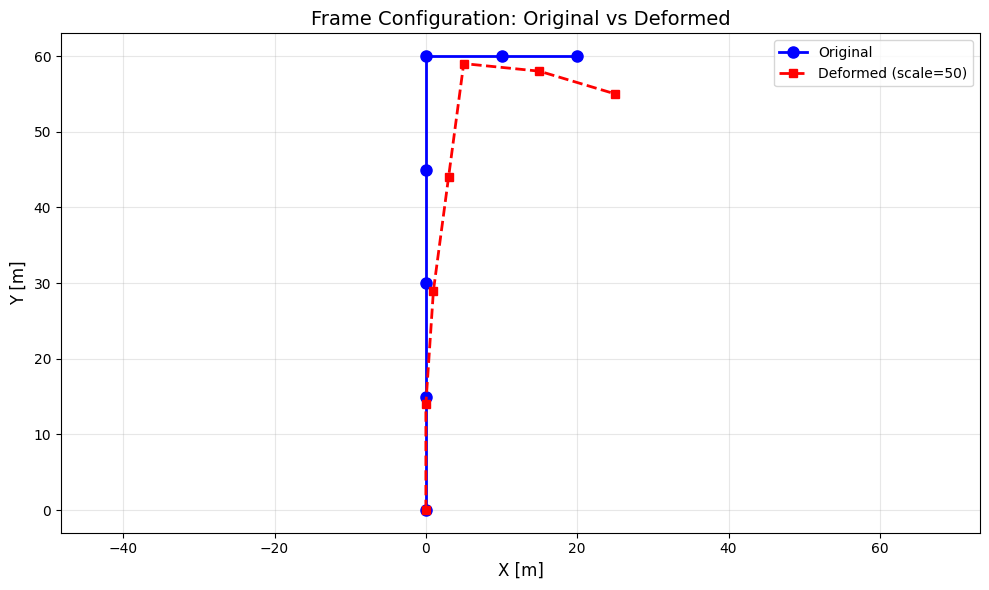

In [6]:
nodes = [
    [0, 0],
    [0, 15],
    [0, 30],
    [0, 45],
    [0, 60],
    [10, 60],
    [20, 60]
]

x = np.array([i for [i, _] in nodes])
y = np.array([j for [_, j] in nodes])

nel = 6

el = 30 * 10**6  # elastic modulus
area = 2         # cross-sectional area
xi = 2/3

bcdof = [0, 1, 2]  # dofs constrained (transverse, axial, slope at node 1)
bcval = [0, 0, 0]

applied_forces = {19: -60}

cfd_results = cfd(nel, NNEL, NDOF, x, y, el, area, xi, bcdof, bcval, applied_forces)

print("\nDOF   Displacement (m)")
for dof in sorted(cfd_results.keys()):
    print(f"{dof:3d}   {cfd_results[dof]:.6e}")

plot_deformed_frame(cfd_results, x, y, scale=50)